In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Data Loading

### Store Data into DataFrame

In [2]:
data_dir = '../../crop'

filepaths = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        
        filepaths.append(fpath)
        labels.append(fold)
        

data_dir = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
data_dir


,filepaths,labels
0,../../crop/C130/c36193479efb089c872ebc488735e9...,C130
1,../../crop/C130/4da597de74ae15f5a304ee93ce4479...,C130
2,../../crop/C130/bcd764fd0fc0f8a548a9cea24e6ac9...,C130
3,../../crop/C130/690c6363f358899eb59efb0ee9ac0a...,C130
4,../../crop/C130/db1e871b3b98ea81975b7a45994fba...,C130
...,...,...
31912,../../crop/KJ600/871e9620c79f258b1364e1ebde2a9...,KJ600
31913,../../crop/KJ600/02d4e0ff5e7864c498c93d71c37d0...,KJ600
31914,../../crop/KJ600/09a85129442d1fa21bbd8771d12ca...,KJ600
31915,../../crop/KJ600/82e61e7df899a6ede16cc977e3161...,KJ600


### Splitt the data

In [3]:
train_df, dummy_df = train_test_split(data_dir, test_size=0.2, shuffle=True, random_state=42)
val_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle=True, random_state=42)

### Data Generators

In [4]:
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2]
)
test_gen = ImageDataGenerator()


train_gen = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
                                      color_mode='rgb', class_mode='categorical', batch_size=16)

val_gen = test_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
                                   color_mode='rgb', class_mode='categorical', batch_size=16)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
                                   color_mode='rgb', class_mode='categorical', batch_size=16)

Found 25533 validated image filenames belonging to 74 classes.
Found 3192 validated image filenames belonging to 74 classes.
Found 3192 validated image filenames belonging to 74 classes.


## Training

In [12]:
# Load EfficientNetB3 as base model
base_model = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="max"
)

# Build the model
model = Sequential([
    base_model,
    BatchNormalization(),
    
    # Add a Dense layer with Batch Normalization and Dropout
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    
    Dense(74, activation='softmax')  # 74 classes
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)   │ (None, 1280)           │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 74)             │        19,018 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,098,922 (450.51 MB)

 Trainable params: 117,583,786 (448.55 MB)

 Non-trainable params: 515,136 (1.97 MB)

In [29]:
# Define the model checkpoint
checkpoint = ModelCheckpoint('best_model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# reduce learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * 0.9

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# TensorBoard
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    )

# CSV Logger
csv_logger = tf.keras.callbacks.CSVLogger('training.log', append=True)

callbacks = [checkpoint, early_stopping, reduce_lr, lr_scheduler, tensorboard, csv_logger]

In [30]:
history=model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

Epoch 1/50


2024-11-15 17:46:10.200584: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-15 17:46:10.318996: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-15 17:46:10.521537: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
E0000 00:00:1731689172.855946  102036 gpu_timer.cc:82] 

 951/1596 ━━━━━━━━━━━━━━━━━━━━ 3:35 335ms/step - accuracy: 0.1187 - loss: 7.3328

2024-11-15 17:52:55.540550: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-15 17:52:55.652361: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-15 17:52:55.840578: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
E0000 00:00:1731689577.890332  102036 gpu_timer.cc:82] 

1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.1746 - loss: 6.6009
Epoch 1: val_accuracy improved from -inf to 0.59492, saving model to best_model.keras
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 845s 425ms/step - accuracy: 0.1747 - loss: 6.5999 - val_accuracy: 0.5949 - val_loss: 2.4633 - learning_rate: 0.0010
Epoch 2/50
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5736 - loss: 2.3657
Epoch 2: val_accuracy improved from 0.59492 to 0.70833, saving model to best_model.keras
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 582s 364ms/step - accuracy: 0.5736 - loss: 2.3656 - val_accuracy: 0.7083 - val_loss: 1.4937 - learning_rate: 0.0010
Epoch 3/50
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6936 - loss: 1.5042
Epoch 3: val_accuracy improved from 0.70833 to 0.78289, saving model to best_model.keras
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 580s 363ms/step - accuracy: 0.6936 - loss: 1.5041 - val_accuracy: 0.7829 - val_loss: 1.0625 - learning_rate: 0.0010
Epoch 4/50
1596/1596 ━━━━━━━━━━━━━━━

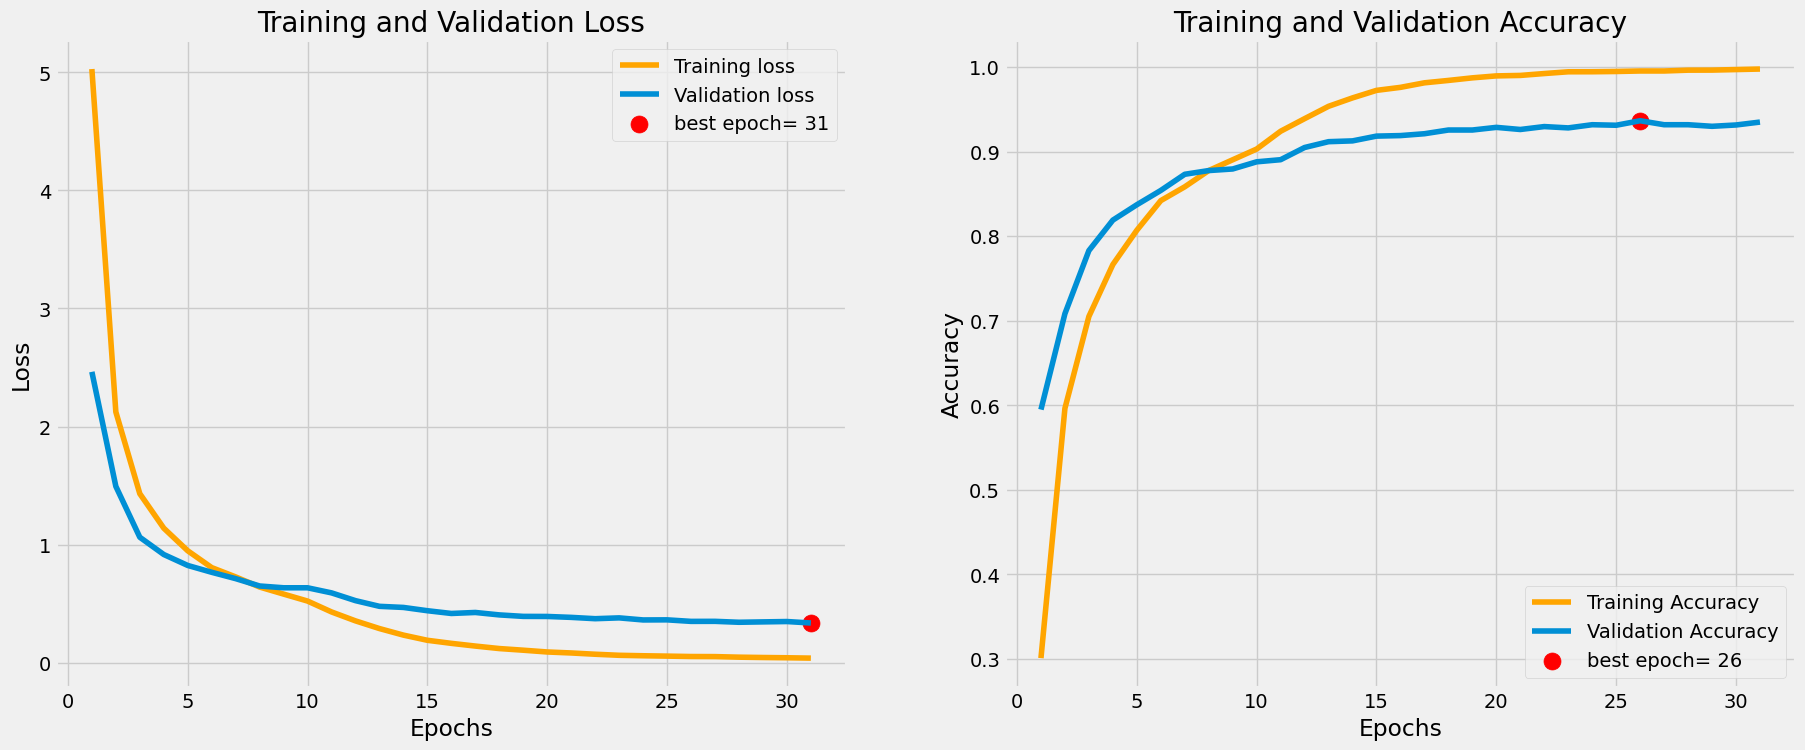

In [31]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'orange', label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'red', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'orange', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen)
test_score = model.evaluate(test_gen)
valid_score = model.evaluate(val_gen)

pd.DataFrame({
    '': ['Loss','Accuracy'],
    'Train score': [train_score[0], f'{round(train_score[1] * 100, 2)}%'],
    'Valid score': [valid_score[0], f'{round(valid_score[1] * 100, 2)}%'],
    'Test score': [test_score[0], f'{round(test_score[1] * 100, 2)}%']})

1596/1596 ━━━━━━━━━━━━━━━━━━━━ 167s 105ms/step - accuracy: 0.9995 - loss: 0.0328
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.9364 - loss: 0.3475
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.9314 - loss: 0.3740


,,Train score,Valid score,Test score
0,Loss,0.033099,0.349915,0.33773
1,Accuracy,99.93%,93.64%,93.89%


## Inference from Dataset

In [ ]:
model = load_model('results_efficientnetv2l/best_model.keras')

In [ ]:
def plot_predictions_from_generator(generator, model, num_images = 16):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    class_indices = generator.class_indices
    class_indices = dict((v,k) for k,v in class_indices.items())
    predicted_labels = [class_indices[k] for k in predicted_labels]
    true_labels = [class_indices[k] for k in true_labels]
    plt.figure(figsize=(15, 15))

    for i in range(num_images):
        image = images[i] / 255
        plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        title = f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}'
        plt.title(title)
        plt.axis('off') 
    plt.show()

I0000 00:00:1732871390.249950 2553039 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


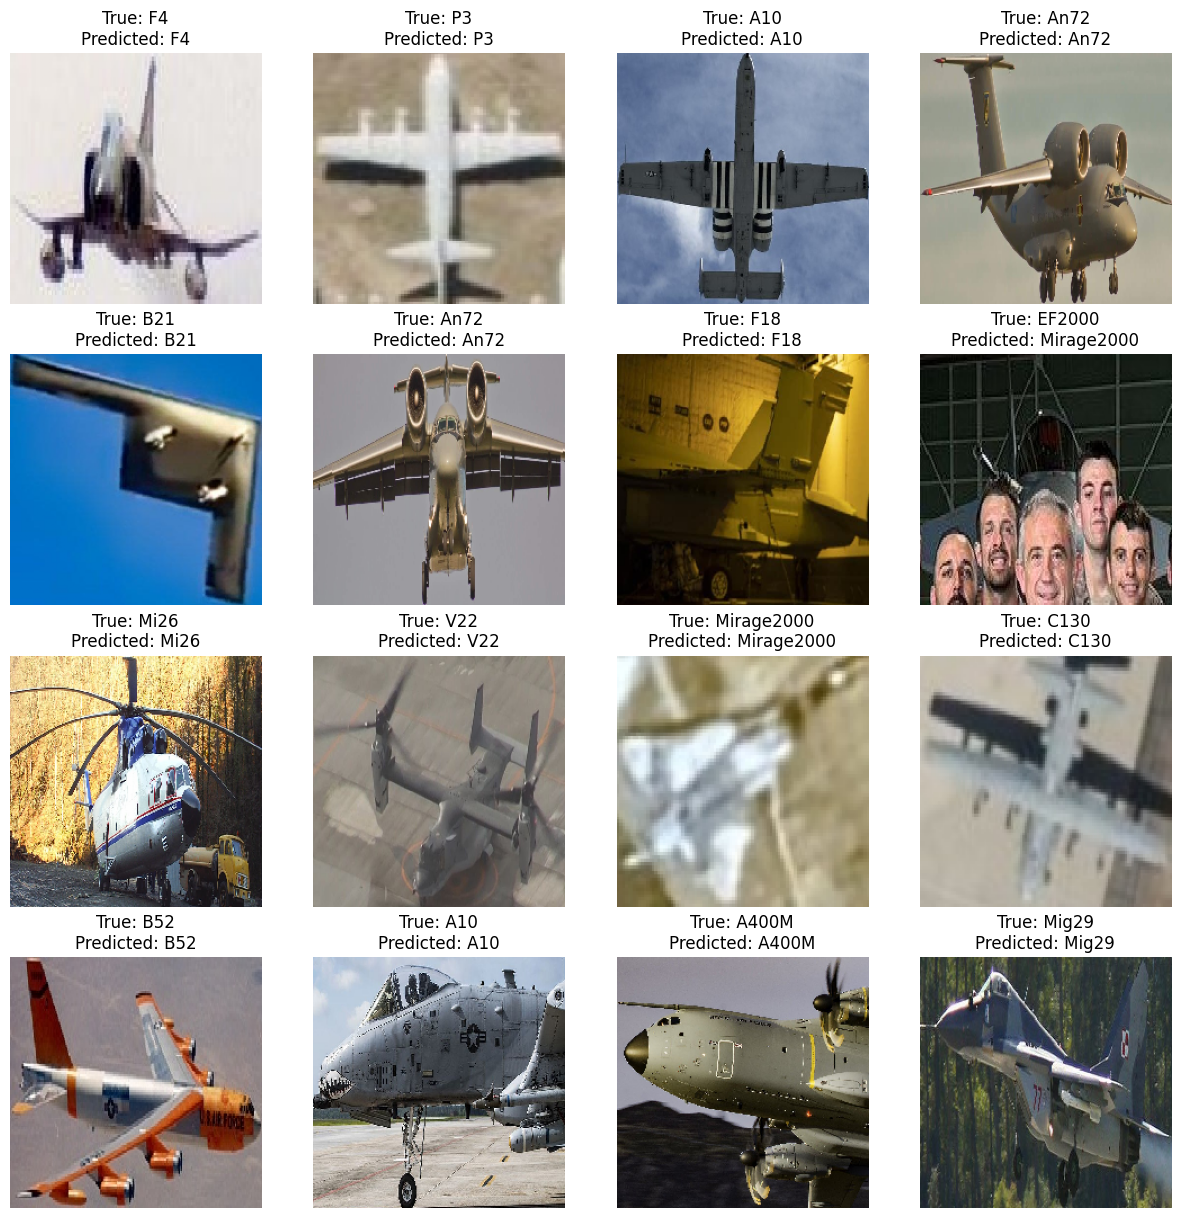

In [18]:
plot_predictions_from_generator(test_gen, model)

In [ ]:
# Plot predictions from single picture
def plot_predictions_from_image(image_path, model):
    true_label = image_path.split('/')[-2]

    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    predicted_label = np.argmax(predictions)
    # number label to class name
    class_indices = train_gen.class_indices
    index_to_class = {v: k for k, v in class_indices.items()}
    predicted_label = index_to_class[predicted_label]
    plt.imshow(plt.imread(image_path))
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


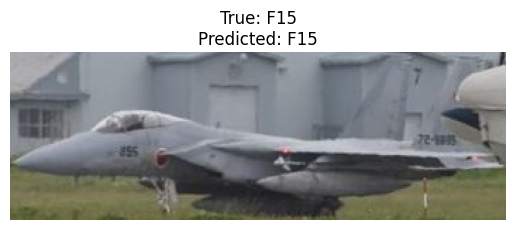

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


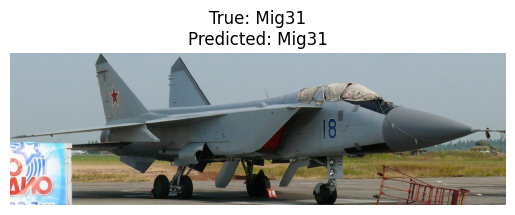

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


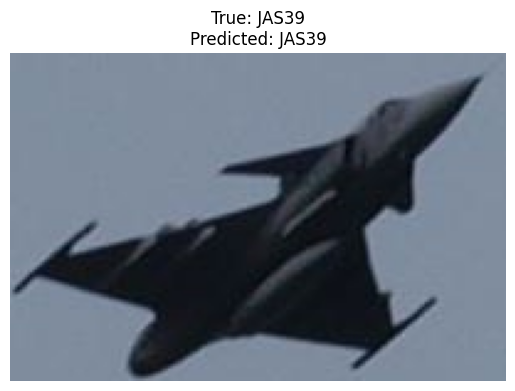

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


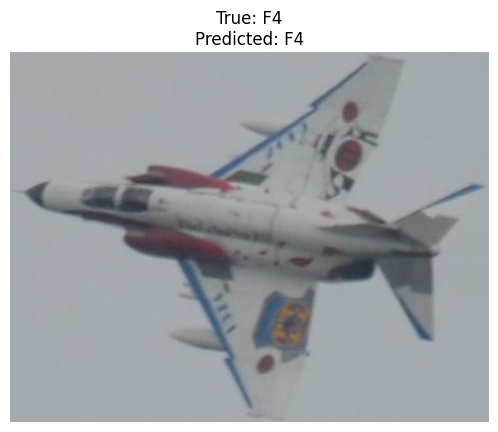

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


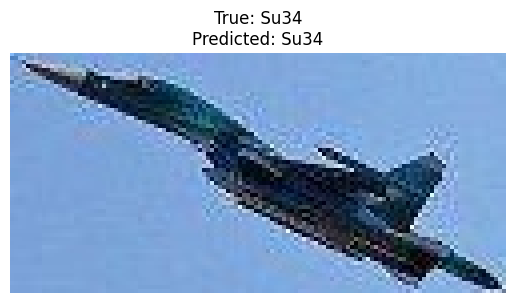

In [ ]:
for i in range(5):
    plot_predictions_from_image(test_df['filepaths'].iloc[i], model)

In [ ]:
class_indices = test_gen.class_indices
class_names = list(class_indices.keys())

true_labels = []
predicted_labels = []

for i in range(len(test_gen)):
    print(f'Batch {i + 1}')
    images, labels = test_gen[i]
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

              precision    recall  f1-score   support

         A10       0.95      0.89      0.92        64
       A400M       0.88      0.95      0.91        37
       AG600       0.88      1.00      0.93        28
        AH64       0.94      0.92      0.93        49
        AV8B       0.88      0.85      0.87        27
       An124       0.95      1.00      0.97        19
        An22       1.00      0.60      0.75         5
       An225       1.00      0.75      0.86         4
        An72       1.00      0.96      0.98        23
          B1       0.90      0.98      0.94        57
          B2       0.98      0.94      0.96        53
         B21       0.83      1.00      0.91         5
         B52       0.96      0.90      0.93        58
       Be200       0.92      0.89      0.91        27
        C130       0.93      0.95      0.94       125
         C17       0.93      0.93      0.93        86
          C2       0.95      0.96      0.96        82
        C390       0.91    

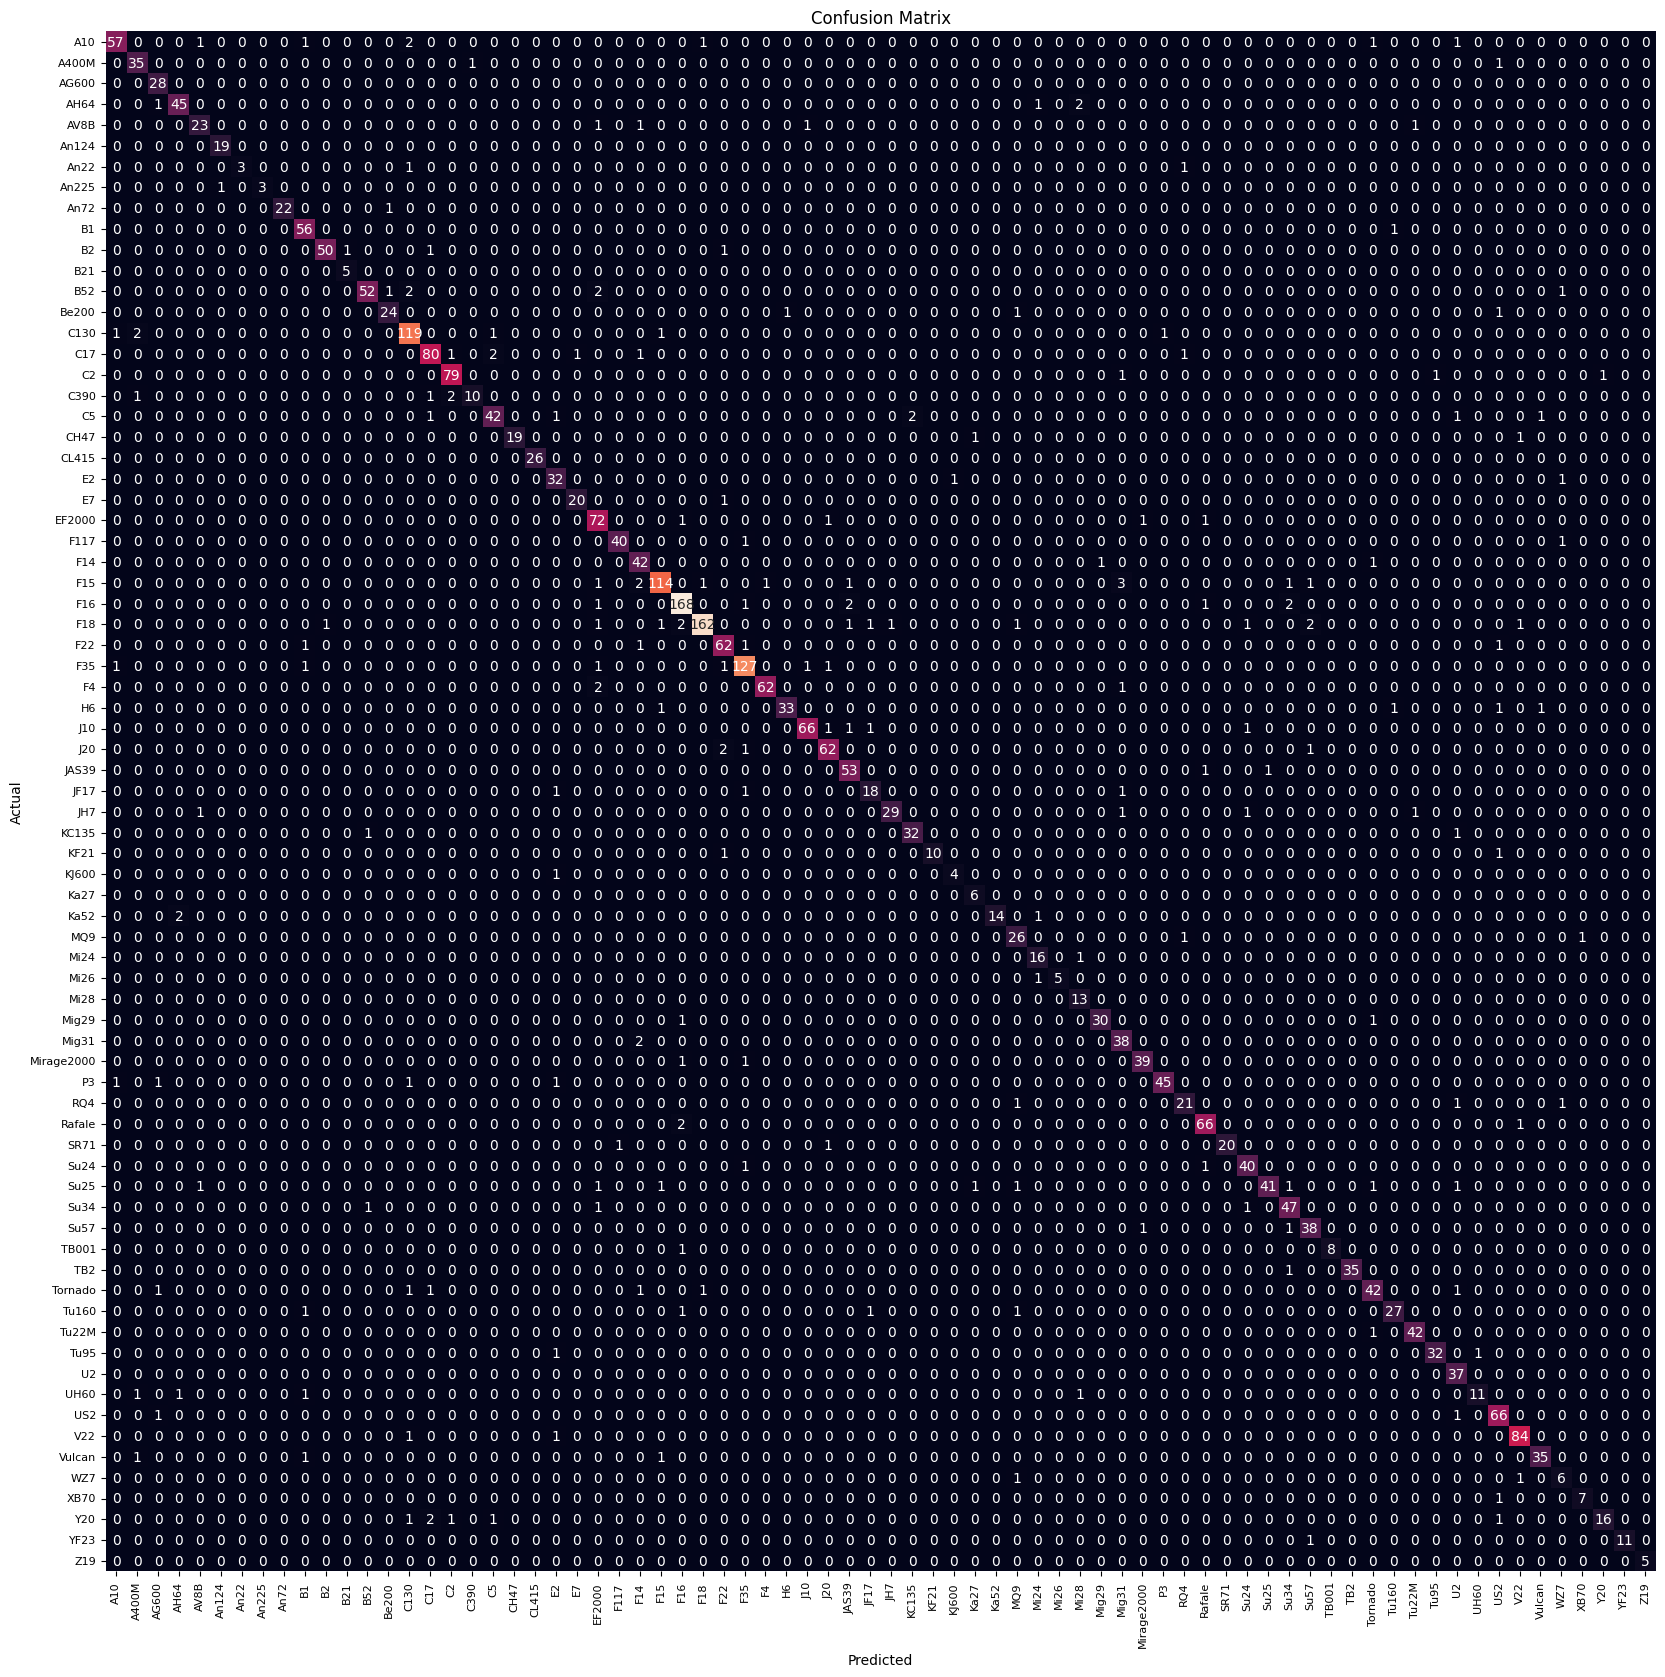

In [46]:
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
#cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', color='blue', xticklabels=class_names, yticklabels=class_names, cbar=False)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
#plt.tight_layout()
plt.show()


## Inference without Lables

In [8]:
model = load_model('results_efficientnetv2l/best_model.keras')

classes = [
    "A-10", "A-400M", "AG-600", "AH-64", "AV-8B", "An-124", "An-22", "An-225", "An-72", 
    "B-1", "B-2", "B-21", "B-52", "Be-200", "C-130", "C-17", "C-2", "C-390", "C-5", 
    "CH-47", "CL-415", "E-2", "E-7", "EF-2000", "F-117", "F-14", "F-15", "F-16", "F-22", 
    "F-35", "F-4", "F/A-18", "H-6", "J-10", "J-20", "JAS-39", "JF-17", "JH-7", "KC-135", 
    "KF-21", "KJ-600", "Ka-27", "Ka-52", "MQ-9", "Mi-24", "Mi-26", "Mi-28", "Mig-29", 
    "Mig-31", "Mirage2000", "P-3", "RQ-4", "Rafale", "SR-71", "Su-24", "Su-25", "Su-34", 
    "Su-57", "TB-001", "TB-2", "Tornado", "Tu-160", "Tu-22M", "Tu-95", "U-2", "UH-60", 
    "US-2", "V-22", "Vulcan", "WZ-7", "XB-70", "Y-20", "YF-23", "Z-19"
]

# Plot predictions from images without lables
def plot_predictions_for_folder(folder_path, model):
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = np.expand_dims(image, axis=0)

        predictions = model.predict(image)
        predicted_label = np.argmax(predictions)

        plt.imshow(plt.imread(image_path))
        plt.title(f'Filename: {image_name}\nPredicted Lable: {classes[predicted_label]}')
        plt.axis('off')
        plt.show()

/opt/miniconda3/envs/introai/lib/python3.10/site-packages/keras/src/trainers/trainer.py:213: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


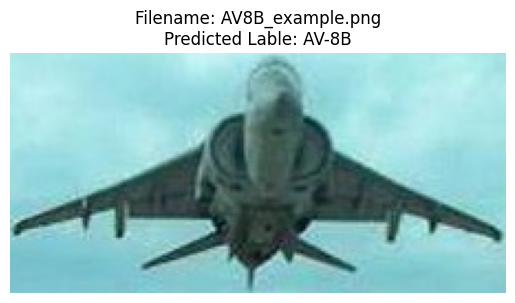

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


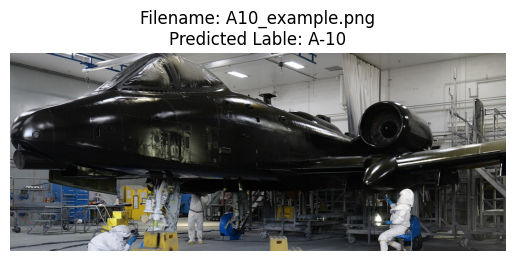

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


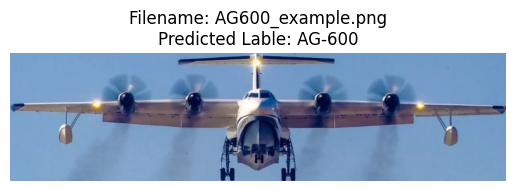

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


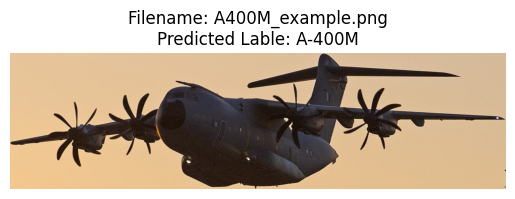

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


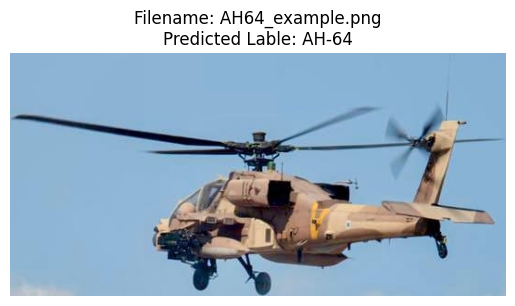

In [10]:
plot_predictions_for_folder("./test_images", model)